In [1]:
import pandas as pd
from pathlib import Path
import librosa
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys

sys.path.append(str(Path().resolve().parent))

from utils.audio_processing import extract_mfcc_from_file, visualize_waveform_and_mel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from kneed import KneeLocator

In [2]:
# Inside the container, this points to the mounted dataset
data_path = Path("../data/raw/common_voice/validated.tsv")
df = pd.read_csv(data_path, sep="\t")
print("Initial shape:",df.shape)

Initial shape: (170004, 13)


/var/folders/l2/8qnx0nk95t17n63yc976q7c80000gn/T/ipykernel_58123/2188492718.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep="\t")


In [3]:
df.head()

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,01648c1613193e9f272373de6867c358d542ae833de4da...,common_voice_ru_26587318.mp3,83c950bce49b612ff614ed9d9522c1934f4e5b564ab524...,"К сожалению, эти предложения не нашли отражени...",NaN,2,0,NaN,NaN,NaN,NaN,ru,NaN
1,02e1bc351debae39ddf3d326476f7b83ad483a858e725d...,common_voice_ru_38513379.mp3,883f73b256ec7049e60d4c19121eb1ddadb734a228937a...,"Эти меры важны для того, чтобы базировать посл...",NaN,2,1,NaN,NaN,говорю как дурной подносовой прикольчик,NaN,ru,NaN
2,0371548939227335ee65bbe0e40f05bc65c75d1e6f4cb5...,common_voice_ru_36292648.mp3,93db023ae3b736a5d936341fa63ebae2129ce89b564336...,"Толпа озвереет, будет тереться, ощетинит ножки...",NaN,2,0,NaN,NaN,NaN,NaN,ru,NaN
3,07cbb3f751afca6ebf8e35b0732e2ed823ecacafe3e60d...,common_voice_ru_40069887.mp3,b9ca175a2ff3231b79f3885bc8250658568b02fc5e6af8...,Хотя Таиланд и не является членом Конференции ...,NaN,2,0,NaN,NaN,NaN,NaN,ru,NaN
4,081340f4cbaab50d8b9606a52488eb0614edd77eb782a4...,common_voice_ru_19468869.mp3,4a6b97d82dfd62d49aa4a6c07fca7664af34c0150145f9...,"Если не будет возражений, я буду считать, что ...",NaN,2,0,NaN,NaN,NaN,NaN,ru,NaN


In [4]:
# Showing columns to inspect
print("Columns in validated.tsv:", df.columns.tolist())

Columns in validated.tsv: ['client_id', 'path', 'sentence_id', 'sentence', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment']


In [5]:
# Dropping rows with missing or unknown age
df = df.dropna(subset=["age"])
df = df[df["age"] != "unknown"]

In [6]:
print("After dropping missing/unknown ages:", df.shape)

After dropping missing/unknown ages: (131103, 13)


In [7]:
# Checking all unique age values
print("Unique age labels:")
print(sorted(df["age"].unique()))

Unique age labels:
['fifties', 'fourties', 'sixties', 'teens', 'thirties', 'twenties']


In [8]:
# Defining age bins
def bin_age(age):
    if age in ["teens"]:
        return "teen"
    elif age in ["twenties"]:
        return "young_adult"
    elif age in ["thirties", "forties"]:
        return "adult"
    elif age in ["fifties", "sixties"]:
        return "middle_aged"
    elif age in ["seventies", "eighties", "nineties"]:
        return "senior"
    else:
        return "unknown"

In [9]:
# Applying binning function to create new column
df["age_group"] = df["age"].apply(bin_age)

# Dropping any that failed binning (i.e., stayed 'unknown')
df = df[df["age_group"] != "unknown"]

In [10]:
# Preview result
print(df["age_group"].value_counts())
df[["path", "age", "age_group"]].head()

young_adult    58609
adult          27144
teen           15516
middle_aged     5090
Name: age_group, dtype: int64


,path,age,age_group
6,common_voice_ru_23236368.mp3,twenties,young_adult
14,common_voice_ru_23349462.mp3,twenties,young_adult
21,common_voice_ru_22733298.mp3,twenties,young_adult
25,common_voice_ru_39782324.mp3,thirties,adult
27,common_voice_ru_22750201.mp3,thirties,adult


In [11]:
# Paths
clips_dir = Path("../data/raw/common_voice/clips/")
processed_dir = Path("../data/processed/")
processed_dir.mkdir(exist_ok=True, parents=True)

In [12]:
# Librosa settings
SAMPLE_RATE = 16000
MAX_DURATION = 3  # seconds
MAX_LEN = SAMPLE_RATE * MAX_DURATION  # samples
NUM_MFCC = 13

In [13]:
np.random.seed(42)

In [14]:
# Feature Extraction Function
def extract_mfcc(file_path, sample_rate=16000, num_mfcc=13, max_len=48000):
    try:
        audio, sr = librosa.load(str(file_path), sr=sample_rate)

        if len(audio) > max_len:
            audio = audio[:max_len]
        else:
            audio = np.pad(audio, (0, max_len - len(audio)))

        mfcc_feat = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc)
        return mfcc_feat
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [15]:
# Extraction Process
features = []
labels = []

print("Extracting MFCCs...")

for _, row in tqdm(df.iterrows(), total=len(df)):
    path = clips_dir / row["path"]
    mfcc = extract_mfcc_from_file(path)

    if mfcc is not None:
        features.append(mfcc)
        labels.append(row["age_group"])

features = np.array(features)
labels = np.array(labels)

print(f"Extracted features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

Extracting MFCCs...


  0%|          | 0/106359 [00:00<?, ?it/s]

Extracted features shape: (106359, 13, 94)
Labels shape: (106359,)


In [16]:
X = np.array(features)
y = np.array(labels)

In [17]:
# Encoding String Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Saving label mapping for use in evaluation
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'adult': 0, 'middle_aged': 1, 'teen': 2, 'young_adult': 3}


In [18]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (85087, 13, 94)
Test set shape: (21272, 13, 94)


In [19]:
# Feature Scaling (Standartization per MFCC)
N, F, T = X_train.shape
X_train_flat = X_train.reshape((N, F * T))
X_test_flat = X_test.reshape((X_test.shape[0], F * T))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Reshaping back
X_train = X_train_scaled.reshape((N, F, T))
X_test = X_test_scaled.reshape((X_test.shape[0], F, T))

print("Feature scaling complete.")

Feature scaling complete.


Visualizing: common_voice_ru_24272508.mp3
Signal shape: (48000,), Mel shape: (128, 94)


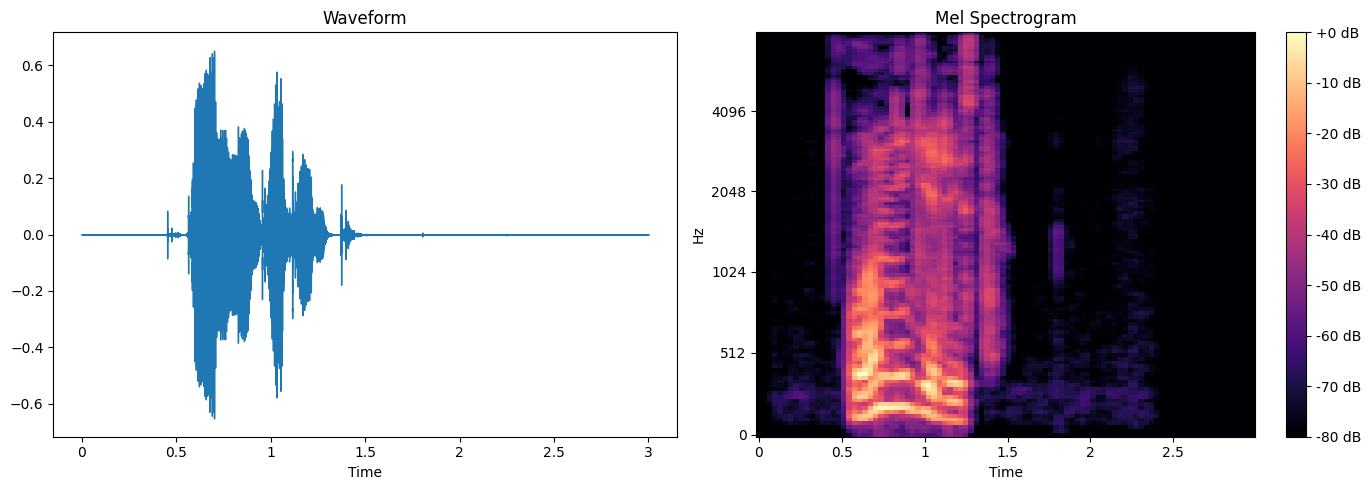

Visualizing: common_voice_ru_30515827.mp3
Signal shape: (48000,), Mel shape: (128, 94)


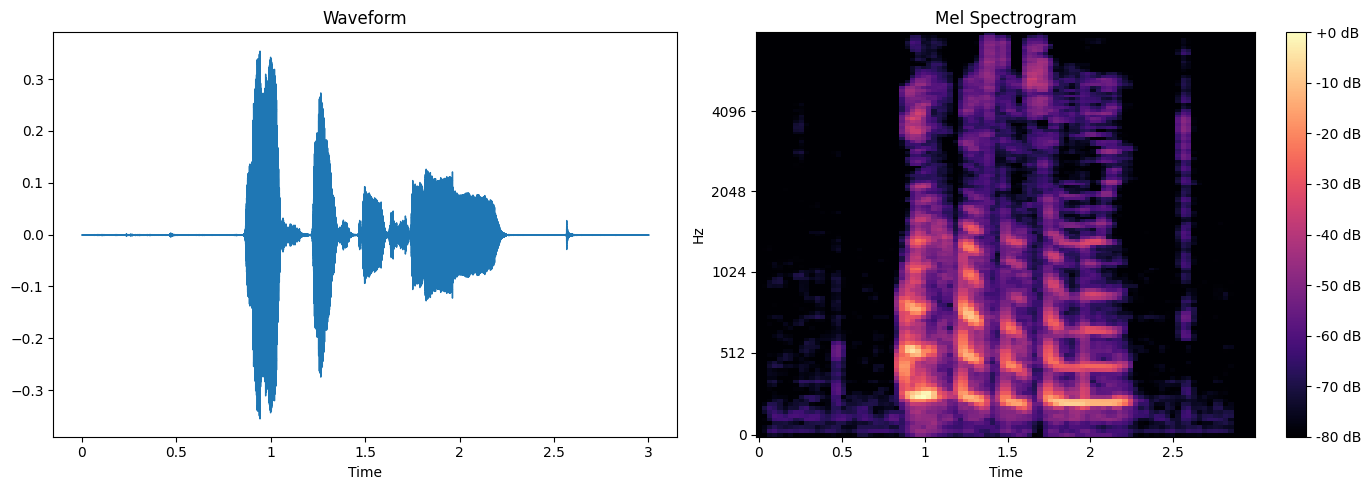

Visualizing: common_voice_ru_30477806.mp3
Signal shape: (48000,), Mel shape: (128, 94)


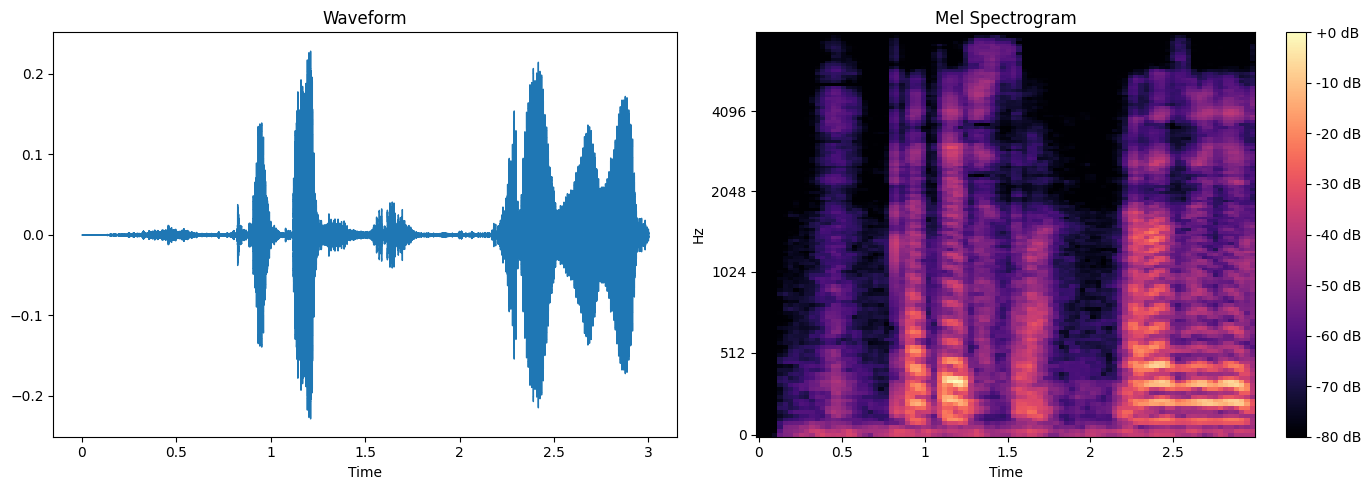

In [20]:
# Visualization on 3 sample waveforms
sample_paths = df["path"].sample(3, random_state=42).values

for p in sample_paths:
    print(f"Visualizing: {p}")
    visualize_waveform_and_mel(clips_dir / p)

# PCA

In [21]:
# Flattening the MFCCs
X_flat = X.reshape((X.shape[0], -1))

In [22]:
# Building descriptive names: mfcc_0_t0, mfcc_0_t1, ...
num_mfcc, num_frames = X.shape[1], X.shape[2]
mfcc_feature_names = [f"mfcc_{i}_t{j}" for i in range(num_mfcc) for j in range(num_frames)]

In [23]:
# Fitting PCA
pca = PCA()
X_pca = pca.fit_transform(X_flat)

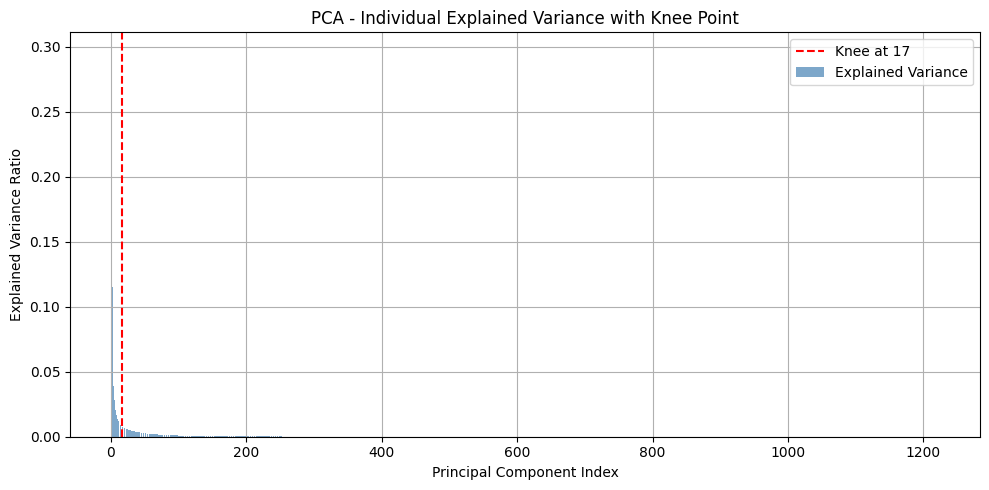

Optimal number of PCA components based on knee: 17


In [24]:
# Plotting individual explained variance
explained_var = pca.explained_variance_ratio_

# Using KneeLocator to find elbow point on individual variance
knee = KneeLocator(
    x=range(1, len(explained_var) + 1),
    y=explained_var,
    curve="convex",
    direction="decreasing"
)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7, color='steelblue', label='Explained Variance')
plt.axvline(x=knee.knee, color='red', linestyle='--', label=f"Knee at {knee.knee}")
plt.xlabel("Principal Component Index")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA - Individual Explained Variance with Knee Point")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Optimal number of PCA components based on knee: {knee.knee}")

In [25]:
# The shape of flattened X
print(f"The shape before PCA: {X_flat.shape}")

The shape before PCA: (106359, 1222)


## MFCCs were shaped like: (230 samples, 13 MFCCs, 94 time steps)
## Flattened → X_flat.shape == (230, 13 * 94) == (230, 1222)

In [26]:
# Using the number of components suggested by KneeLocator
optimal_components = knee.knee

# Applying PCA with selected number of components
pca_final = PCA(n_components=optimal_components)
X_reduced = pca_final.fit_transform(X_flat)

# Wrappin in DataFrame with full descriptive PCA names
component_names = [f"PCA_{i+1}" for i in range(X_reduced.shape[1])]
X_reduced_df = pd.DataFrame(X_reduced, columns=component_names)

# Optional: store the mapping from original MFCC names to PCA loadings
pca_components_df = pd.DataFrame(
    pca_final.components_,  # shape (n_components, n_original_features)
    columns=mfcc_feature_names,
    index=component_names
)

# Saving PCA loadings for interpretation
pca_components_df.to_csv(processed_dir / "pca_loadings.csv")


print(f"PCA applied. New shape: {X_reduced.shape}")

PCA applied. New shape: (106359, 17)


In [27]:
X_reduced_df["label"] = y_encoded

# Train-test split
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(
    X_reduced_df.drop(columns=["label"]),
    X_reduced_df["label"],
    test_size=0.2,
    random_state=42
)

print(f"Reduced Train shape: {X_train_reduced.shape}")
print(f"Reduced Test shape: {X_test_reduced.shape}")

Reduced Train shape: (85087, 17)
Reduced Test shape: (21272, 17)


In [28]:
np.save(processed_dir / "X_train_reduced.npy", X_train_reduced)
np.save(processed_dir / "X_test_reduced.npy", X_test_reduced)
np.save(processed_dir / "y_train.npy", y_train)
np.save(processed_dir / "y_test.npy", y_test)

print("All reduced features and labels saved to /data/processed/")

All reduced features and labels saved to /data/processed/
